In [1]:
import numpy as np
import matplotlib.pyplot as plt
import select_work
import codons
import Sequencing.Visualize
import scipy.stats
import matplotlib.cm
import matplotlib.gridspec as gridspec
import pausing
import brewer2mpl
import pandas
capture = dict(matplotlib.rcParams)
import seaborn
matplotlib.rcParams.update(capture)
import cartoon

In [4]:
experiments = select_work.build_all_experiments()
enrichments = select_work.load_all_enrichments()

In [5]:
experiment = experiments['belgium_2014_12_10']['WT_1_FP']
buffered_codon_counts = experiment.read_file('buffered_codon_counts', specific_keys={'relaxed', 'identities'})
codon_counts = {name: buffered_codon_counts[name]['relaxed']['start_codon':('stop_codon', 1)] for name in buffered_codon_counts}

In [6]:
def get_gradient_labels(name_order): 
    gradient_fractions = [select_work.gerashchenko_fraction(name) for name in name_order]
 
    gradient_labels = [str(num) + ('/{0}x'.format(denom) if denom != 1 else 'x')
                       for num, denom, rep in gradient_fractions
                      ]

    return tuple(gradient_labels)

def bracket_below_range(x_min, x_max, ax, color='black'):
    bracket_x_buffer = 0
    bracket_height = 0.02
    bracket_y_buffer = -0.09
    
    left, _ = ax.transLimits.transform([x_min, 0])
    right, _ = ax.transLimits.transform([x_max, 0])

    bottom = bracket_y_buffer
    top = bottom + bracket_height

    path = [[left - bracket_x_buffer, top],
            [left - bracket_x_buffer, bottom],
            [right + bracket_x_buffer, bottom],
            [right + bracket_x_buffer, top],
           ]

    patch = plt.Polygon(path,
                        color=color,
                        fill=False,
                        closed=False,
                        clip_on=False,
                        transform=ax.transAxes,
                       )

    ax.add_patch(patch)
    
def scatter_pair(enrichments, x_name, y_name,
                 offset=0,
                 text_location='upper right',
                 ax=None,
                 manual_ratios=(0.25, -1.),
                 manual_alignments=('center', 'top')
                ):
    if ax == None:
        fig, ax = plt.subplots(figsize=(16, 16))
    else:
        fig = ax.get_figure()

    xs = np.array([enrichments[x_name]['codon', offset, codon_id] for codon_id in codons.non_stop_codons])
    ys = np.array([enrichments[y_name]['codon', offset, codon_id] for codon_id in codons.non_stop_codons])

    xs = np.log2(xs)
    ys = np.log2(ys)

    Sequencing.Visualize.enhanced_scatter(xs, ys, ax,
                                          color_by_density=False,
                                          show_p_value=False,
                                          marker_size=8,
                                          do_fit=False,
                                          text_location=text_location,
                                          text_size=12,
                                          text_weight='bold',
                                          color_by_correlation=True,
                                          in_log_space=True,
                                         )
    
    labels = np.array(codons.non_stop_codons)
    to_label = (labels == 'CGA') | (labels == 'CGG')
    pausing.label_scatter_plot(ax, xs, ys, labels, to_label,
                               vector='manual',
                               manual_ratios=manual_ratios,
                               manual_alignments=manual_alignments,
                               initial_distance=15,
                               arrow_alpha=0.5,
                              )

    ax.set_xlim(-3.5, 2.5)
    ax.set_ylim(-3.5, 2.5)
    ax.set_aspect('equal')

    kwargs = {'color': 'black',
              'alpha': 0.3,
             }

    ax.axhline(0, **kwargs)
    ax.axvline(0, **kwargs)
        
    Sequencing.Visualize.draw_diagonal(ax, alpha=0.3)

def correlation_heatmap_cartoon(enrichments,
                                CHX_names, noCHX_names, gradient_names,
                                CHX_1_name, CHX_2_name, noCHX_1_name, noCHX_2_name,
                                offset=0,
                                show_tAI=True,
                                show_scatters=True,
                                show_cartoon=True,
                                show_matrix=True,
                                draw_dividing_line=True,
                                tRNA_values='tAI',
                                draw_letters=True,
                                size=12,
                                annotate_matrix=False,
                                draw_p_value_line=False,
                               ):    
    CHX_names, CHX_short_labels, CHX_labels = zip(*CHX_names)
    noCHX_names, noCHX_short_labels, noCHX_labels = zip(*noCHX_names)

    names = CHX_names + noCHX_names
    short_labels = CHX_short_labels + noCHX_short_labels
    long_labels = CHX_labels + noCHX_labels
    
    CHX_1_label = long_labels[names.index(CHX_1_name)]
    CHX_2_label = long_labels[names.index(CHX_2_name)]
    noCHX_1_label = long_labels[names.index(noCHX_1_name)]
    noCHX_2_label = long_labels[names.index(noCHX_2_name)]
    
    tAIs = pausing.load_tRNA_copy_numbers(tRNA_values)
    tAI_values = [tAIs[codon] for codon in codons.non_stop_codons]
    
    tAI_height = 0.30
    tAI_width = 1.02
    
    row_gap = 0.1
    
    scatter_height = scatter_width = 0.2175
    scatter_gap = 0.015
    
    matrix_height = matrix_width = 0.45
    matrix_gap = 0.12
    
    cartoon_height = scatter_height
    cartoon_width = tAI_width
    
    total_width = tAI_width
    total_height = tAI_height + row_gap + matrix_height + 2. / 3 * row_gap + cartoon_height
    
    fig = plt.figure(figsize=(size * total_width, size * total_height))
    
    tAI_ax = fig.add_axes([0, 0, tAI_width / total_width, tAI_height / total_height])
    
    matrix_x = 2 * scatter_width + scatter_gap + matrix_gap
    matrix_y = tAI_height + row_gap * 0.7
    matrix_ax = fig.add_axes([matrix_x / total_width, matrix_y / total_height, matrix_width / total_width, matrix_height / total_height])
        
    cartoon_y = matrix_y + matrix_height + row_gap * 2. / 3
    cartoon_ax = fig.add_axes([0, cartoon_y / total_height, cartoon_width / total_width, cartoon_height / total_height])
    codon_id = 'ACT'
    gene = 'YLR044C'
    font_size = 20
    plot_up_to = 19
    UTR_codons = 3

    cds = cartoon.CodingSequence(cartoon_ax, buffered_codon_counts, gene, font_size=font_size, plot_up_to=plot_up_to, UTR_codons=UTR_codons)
    cds.draw_codon_sequence(0.15, 0.5, highlight_offset=offset, highlight_sequence=codon_id, label='Coding sequence:')
    # Need room for the connecting arrow for non-zero offsets
    if offset == 0:
        y_gap = 2
    else:
        y_gap = 2.5
        
    if offset == 0:
        label = 'Mapped read with {} in A-site:'.format(codon_id)
    elif offset == -1:
        label = 'Mapped read with {} in P-site:'.format(codon_id)
    elif offset == -2:
        label = 'Mapped read with {} in E-site:'.format(codon_id)
    else:
        label='Mapped read with A-site {0:+d} codons downstream of {1}:'.format(-offset, codon_id)
    cds.draw_read(4 - offset, y_gap=y_gap, label=label)
    cds.draw_codon_counts()
    cds.draw_codon_enrichments()
    cds.rectangle_around_everything()
    
    scatter_x = 0
    scatter_y = tAI_height + row_gap * 0.7
    UL_scatter_ax = fig.add_axes([scatter_x / total_width,
                                  (scatter_y + scatter_height + scatter_gap) / total_height,
                                  scatter_width / total_width,
                                  scatter_height / total_height]
                                )
    UR_scatter_ax = fig.add_axes([(scatter_x + scatter_width + scatter_gap) / total_width,
                                  (scatter_y + scatter_height + scatter_gap) / total_height,
                                  scatter_width / total_width,
                                  scatter_height / total_height]
                                )
    LR_scatter_ax = fig.add_axes([(scatter_x + scatter_width + scatter_gap) / total_width,
                                  scatter_y / total_height,
                                  scatter_width / total_width,
                                  scatter_height / total_height]
                                )

    values = [enrichments[name]['codon', offset, codons.non_stop_codons] for name in names]
    df = pandas.DataFrame(np.array(values).T, columns=short_labels)
    clustermap = seaborn.clustermap(df.corr(),
                                    ax=matrix_ax,
                                    cmap=matplotlib.cm.RdBu_r,
                                    #cmap=matplotlib.cm.seismic,
                                    vmin=-1,
                                    vmax=1,
                                    linewidths=0,
                                    cbar_kws=dict(ticks=[-1, 0, 1]),
                                    figsize=(size, size),
                                   )
               
    scatter_kwargs = {'text_location': 'upper left',
                      'offset': offset,
                     }
  
    scatter_pair(enrichments,
                 CHX_2_name, CHX_1_name,
                 ax=UL_scatter_ax,
                 manual_ratios=(1., 0.),
                 manual_alignments=('left', 'center'),
                 **scatter_kwargs)
    
    scatter_pair(enrichments,
                 noCHX_2_name, CHX_1_name,
                 ax=UR_scatter_ax,
                 manual_ratios=(-1., 0.),
                 manual_alignments=('right', 'center'),
                 **scatter_kwargs)
    
    scatter_pair(enrichments,
                 noCHX_2_name, noCHX_1_name,
                 ax=LR_scatter_ax,
                 manual_ratios=(-0.1, -1.),
                 manual_alignments=('center', 'top'),
                 **scatter_kwargs)
    
    UL_scatter_ax.set_xlabel('A-site occupancies (log 2)')
    UL_scatter_ax.xaxis.set_label_position('top')
    UL_scatter_ax.xaxis.set_tick_params(labeltop='off', labelbottom='on')
    UL_scatter_ax.set_ylabel('A-site occupancies (log 2)')
    UL_scatter_ax.yaxis.set_tick_params(labelleft='on', labelright='off')
    
    label_kwargs = dict(xycoords='axes fraction',
                        textcoords='offset points',
                        ha='center',
                        va='center',
                        weight='bold',
                       )
    
    UL_scatter_ax.annotate(CHX_1_label,
                           xy=(0, 0.5),
                           xytext=(-40, 0),
                           rotation=90,
                           color=pausing.dark_CHX,
                           **label_kwargs)
    
    UL_scatter_ax.annotate(CHX_2_label,
                           xy=(0.5, 1),
                           xytext=(0, 20),
                           color=pausing.dark_CHX,
                           **label_kwargs)
    
    UR_scatter_ax.set_xlabel('A-site occupancies (log 2)')
    UR_scatter_ax.xaxis.set_label_position('top')
    UR_scatter_ax.xaxis.set_tick_params(labeltop='off', labelbottom='off')
    UR_scatter_ax.yaxis.set_tick_params(labelleft='off', labelright='off')
    
    LR_scatter_ax.set_ylabel('A-site occupancies (log 2)')
    LR_scatter_ax.yaxis.set_tick_params(labelleft='on', labelright='off')
    
    LR_scatter_ax.annotate(noCHX_1_label,
                           xy=(0, 0.5),
                           xytext=(-40, 0),
                           rotation=90,
                           color=pausing.dark_noCHX,
                           **label_kwargs)
    
    UR_scatter_ax.annotate(noCHX_2_label,
                           xy=(0.5, 1),
                           xytext=(0, 20),
                           color=pausing.dark_noCHX,
                           **label_kwargs
                          )
    if draw_dividing_line:
        matrix_ax.axhline(len(names) - len(CHX_names), color='black', lw=3)
        matrix_ax.axvline(len(CHX_names), color='black', lw=3)
    
    name_to_tAI_correlation = {}
    for name_list in [CHX_names, noCHX_names] + gradient_names:
        for name in name_list:
            if name == None:
                continue
                
            values = enrichments[name]['codon', offset, codons.non_stop_codons]
            rho, p = scipy.stats.spearmanr(values, tAI_values)
            name_to_tAI_correlation[name] = rho
            
    CHX_xs = np.arange(len(CHX_names)) / 3.
    gradient_start = max(CHX_xs) + 1. / 3
    gradient_xs_list = [[gradient_start + i for i, name in enumerate(condition) if name != None] for condition in gradient_names]
    noCHX_start = gradient_start + max(map(len, gradient_names)) - 1 + 1. / 3
    
    # exclude gersarchenko NAR samples from being plotted a second time
    relevant_noCHX_names = [name for name in noCHX_names if 'noCHX' not in name or name.startswith('WT_ribo_YPD')]
    relevant_noCHX_short_labels = tuple([label for name, label in zip(noCHX_names, noCHX_short_labels) if name in relevant_noCHX_names])
    noCHX_xs = noCHX_start + np.arange(len(relevant_noCHX_names)) / 3.
    
    gradient_end = min(noCHX_xs) - 1. / 3
    
    CHX_ys = [name_to_tAI_correlation[name] for name in CHX_names]
    noCHX_ys = [name_to_tAI_correlation[name] for name in relevant_noCHX_names]
    gradient_ys_list = [[name_to_tAI_correlation[name] for name in gradient if name != None] for gradient in gradient_names]
    
    CHX_sigs = [name_to_tAI_correlation[name] for name in CHX_names]
    noCHX_sigs = [name_to_tAI_correlation[name] for name in relevant_noCHX_names]
    gradient_sigs_list = [[name_to_tAI_correlation[name] for name in gradient if name != None] for gradient in gradient_names]
    
    gradient_labels = [name_list[-1].split('_')[0] for name_list in gradient_names]
    gradient_colors = []
    
    bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
    colors = bmap.mpl_colors[:5] + bmap.mpl_colors[6:]
        
    tAI_ax.plot(CHX_xs, CHX_ys, 'o', color='black')
    tAI_ax.plot(noCHX_xs, noCHX_ys, 'o', color='black')
    for gradient_xs, gradient_ys, label in zip(gradient_xs_list, gradient_ys_list, gradient_labels):
        lines, = tAI_ax.plot(gradient_xs, gradient_ys, 'o-', label=label)
        gradient_colors.append(lines.get_color())
        
    y_offset = 0
    for gradient_label, gradient_color in zip(gradient_labels, gradient_colors):
        tAI_ax.annotate(gradient_label,
                        xy=(gradient_end - 1, 0.175),
                        xycoords=('data', 'axes fraction'),
                        xytext=(0, y_offset),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        size=14,
                        color=gradient_color,
                       )
        y_offset -= 14 + 4
        
    tAI_ax.axhline(0, color='black')
    tAI_ax.set_xticks(np.concatenate((CHX_xs, gradient_xs_list[0], noCHX_xs)))
    tAI_ax.set_xlim(-0.25, max(noCHX_xs) + 0.25)
    tAI_ax.set_xticklabels(CHX_short_labels + get_gradient_labels(gradient_names[0]) + relevant_noCHX_short_labels)
    
    # Empirically determined rho value for which 2-tailed p = 1e-4 with N=61
    if draw_p_value_line:
        cutoff = 0.48
        tAI_ax.axhline(cutoff, linestyle='--', color='black', alpha=0.5)
        tAI_ax.annotate('p < $10^{-4}$',
                        xy=(1, cutoff),
                        xycoords=('axes fraction', 'data'),
                        xytext=(-10, -5),
                        textcoords='offset points',
                        va='top',
                        ha='right',
                        size=12,
                       )
        
    #tAI_ax.yaxis.grid(linestyle='-', alpha=0.3)
    
    bracket_below_range(gradient_start, gradient_end, tAI_ax, color='black')
           
    def get_label_properties(name):
        if show_scatters and name in [CHX_1_name, CHX_2_name]:
            color = pausing.dark_CHX
            weight = 'heavy'
        elif show_scatters and name in [noCHX_1_name, noCHX_2_name]:
            color = pausing.dark_noCHX
            weight = 'heavy'
        elif name in CHX_names:
            color = pausing.light_CHX
            weight = 'semibold'
        elif name in noCHX_names:
            color = pausing.light_noCHX
            weight = 'semibold'

        return color, weight

    matrix_ax.xaxis.set_ticks_position('bottom')
    matrix_ax.yaxis.set_ticks_position('left')
    matrix_ax.tick_params(labeltop=False, labelbottom=False)
    matrix_ax.tick_params(labelright=False, labelleft=True)
    matrix_ax.tick_params(axis='both', direction='out', length=4)
    matrix_ax.tick_params(bottom='off')

    ytick_labels = matrix_ax.get_yticklabels()
    # Note: rows are flipped
    for i, label in zip(clustermap.dendrogram_col.reordered_ind, ytick_labels[::-1]):
        color, weight = get_label_properties(names[i])
        label.set_color(color)
        label.set_weight(weight)

    for label in matrix_ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    fig.delaxes(clustermap.ax_row_dendrogram)
            
    for name, label in zip(CHX_names, tAI_ax.get_xticklabels()):
        label.set_color(pausing.light_CHX)
        label.set_rotation(45)
        label.set_ha('right')
        label.set_weight('semibold')
        
    for name, label in zip(relevant_noCHX_names[::-1], tAI_ax.get_xticklabels()[::-1]):
        label.set_color(pausing.light_noCHX)
        label.set_rotation(-45)
        label.set_ha('left')
        label.set_weight('semibold')
        
    for label in tAI_ax.get_xticklabels():
        label.set_size(12)
    
    triangle = matplotlib.patches.Polygon(np.array([[gradient_start, 1.02], [gradient_end, 1.02], [gradient_start, 1.10]]),
                                          transform=tAI_ax.get_xaxis_transform(),
                                          clip_on=False,
                                          color='black',
                                          fill=False,
                                         )

    tAI_ax.add_patch(triangle)
    tAI_ax.xaxis.tick_bottom()
    
    tAI_ax.set_ylabel('Rank correlation of\nA-site occupancy with 1 / tAI',
                      size=16,
                      family='serif',
                     )
    
    for label in tAI_ax.get_yticklabels():
        label.set_size(12)
    
    tAI_ax.annotate('CHX',
                    xy=(max(CHX_xs) / 2., 1),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, -10),
                    textcoords='offset points',
                    ha='center',
                    va='top',
                    color=pausing.light_CHX,
                    size=16,
                    weight='bold',
                 )
    
    tAI_ax.annotate('CHX concentration gradient',
                    xy=((gradient_start + gradient_end) / 2., 1),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, -10),
                    textcoords='offset points',
                    ha='center',
                    va='top',
                    size=16,
                    weight='bold',
                 )
    
    tAI_ax.annotate('Gerashchenko NAR',
                    xy=((gradient_start + gradient_end) / 2., 0),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, -35),
                    textcoords='offset points',
                    ha='center',
                    va='top',
                    size=16,
                 )
    
    tAI_ax.annotate('no-CHX',
                    xy=((gradient_end + 1. / 3 + max(noCHX_xs)) / 2., 1),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, -10),
                    textcoords='offset points',
                    ha='center',
                    va='top',
                    size=16,
                    color=pausing.light_noCHX,
                    weight='bold',
                 )
    
    if draw_letters:
        cartoon_ax.annotate('A',
                            xy=(0, 1),
                            xycoords='axes fraction',
                            xytext=(-40, -20),
                            textcoords='offset points',
                            ha='right',
                            va='top',
                            size=30,
                            weight='bold',
                           )
        
        UL_scatter_ax.annotate('B',
                            xy=(0, 1),
                            xycoords='axes fraction',
                            xytext=(-25, 0),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            size=30,
                            weight='bold',
                           )

        matrix_ax.annotate('C',
                           xy=(0, 1),
                           xycoords='axes fraction',
                           xytext=(-25, 15),
                           textcoords='offset points',
                           ha='right',
                           size=30,
                           weight='bold',
                          )

        tAI_ax.annotate('D',
                        xy=(0, 1),
                        xycoords='axes fraction',
                        xytext=(-25, 0),
                        textcoords='offset points',
                        ha='right',
                        va='bottom',
                        size=30,
                        weight='bold',
                       )
    
    tAI_ax.set_ylim(-0.45, 0.8)
    
    if not show_tAI:
        fig.delaxes(tAI_ax)
        
    if not show_scatters:
        for ax in (UL_scatter_ax, UR_scatter_ax, LR_scatter_ax):
            fig.delaxes(ax)
            
    if not show_cartoon:
        fig.delaxes(cartoon_ax)
        
    if not show_matrix:
        fig.delaxes(matrix_ax)
        fig.delaxes(clustermap.cax)
        fig.delaxes(clustermap.ax_col_dendrogram)
        
    if annotate_matrix:
        matrix_ax.annotate('CHX',
                           xy=(len(CHX_names) / 2., 0),
                           xycoords=('data', 'axes fraction'),
                           xytext=(0, -10),
                           textcoords='offset points',
                           color=pausing.light_CHX,
                           size=20,
                           weight='bold',
                           va='top',
                           ha='center',
                          )
        
        matrix_ax.annotate('no-CHX',
                           xy=(len(CHX_names) + len(noCHX_names) / 2., 0),
                           xycoords=('data', 'axes fraction'),
                           xytext=(0, -10),
                           textcoords='offset points',
                           color=pausing.light_noCHX,
                           size=20,
                           weight='bold',
                           va='top',
                           ha='center',
                          )
        
    return fig

In [37]:
CHX_names = [
    ('WT_2_FP', 'Ours', 'Ours (CHX)'),
    ('Footprints-rich-1', 'Ingolia', 'Ingolia (CHX)'),
    ('footprints_for_exponential_vegetative_cells_of_the_strain_gb15_used_for_the_traditional_timecourse', 'Brar', 'Brar (CHX)'),
    ('Initial_rep1_foot', 'Ger. PNAS', 'Gerashchenko PNAS (CHX)'),
    ('dunn_elife', 'Dunn', 'Dunn (CHX)'),
    ('non_multiplexed', 'Artieri', 'Artieri (CHX)'),
    ('S._cerevisiae_Ribo-seq_Rep_1', 'McManus', 'McManus (CHX)'),
    ('WT_Ribosome_Footprint_1', 'Zinshteyn', 'Zinshteyn (CHX)'),
    ('Cycloheximide_replicate_1', 'Lareau', 'Lareau (CHX)'),
    ('WT_ribo_YPD_rep1', 'Nedialkova', 'Nedialkova (CHX)'),
    ('sec63mVenusBirA_+CHX_7minBiotin_input', 'Jan', 'Jan (no CHX)'),
    ('Om45mVenusBirA_+CHX_2minBiotin_input', 'Williams', 'Williams (CHX)'),
]

noCHX_names = [
    ('oxidative_noCHX', 'Ger. NAR ox.', 'Gerashchenko NAR (no CHX)'),
    ('heatshock_noCHX', 'Ger. NAR heat', 'Gerashchenko NAR (no CHX)'),
    ('unstressed_noCHX', 'Ger. NAR un.', 'Gerashchenko NAR (no CHX)'),
    ('wild-type_CHX', 'Guydosh', 'Guydosh (no CHX)'),
    ('RPF', 'Weinberg', 'Weinberg (no CHX)'),
    ('WT_footprint', 'Pop', 'Pop (no CHX)'),
    ('Untreated_replicate_1', 'Lareau', 'Lareau (no CHX)'),
    ('ribosome_footprints_for_wildtype', 'Gardin', 'Gardin (no CHX)'),
    ('WT_ribo_YPD_noCHX_rep1', 'Nedialkova', 'Nedialkova (no CHX)'),
    ('sec63mVenusBirA_-CHX_7minBiotin_input', 'Jan', 'Jan (no CHX)'),
    ('Om45mVenusBirA_-CHX_2minBiotin_input', 'Williams', 'Williams (no CHX)'),
]

gradient_names = [
    ['unstressed_100x_CHX_rep1',
     'unstressed_8x_CHX',
     'unstressed_1x_CHX',
     'unstressed_1_4x_CHX',
     'unstressed_1_16x_CHX',
     'unstressed_1_64x_CHX',
     'unstressed_noCHX',
    ],
    ['oxidative_100x_CHX_rep1',
     'oxidative_8x_CHX',
     'oxidative_1x_CHX',
     'oxidative_1_4x_CHX',
     'oxidative_1_16x_CHX',
     'oxidative_1_64x_CHX',
     'oxidative_noCHX',
    ],
    [None,
     None,
     'heatshock_1x_CHX',
     None,
     None,
     None,
     'heatshock_noCHX',
    ],
]

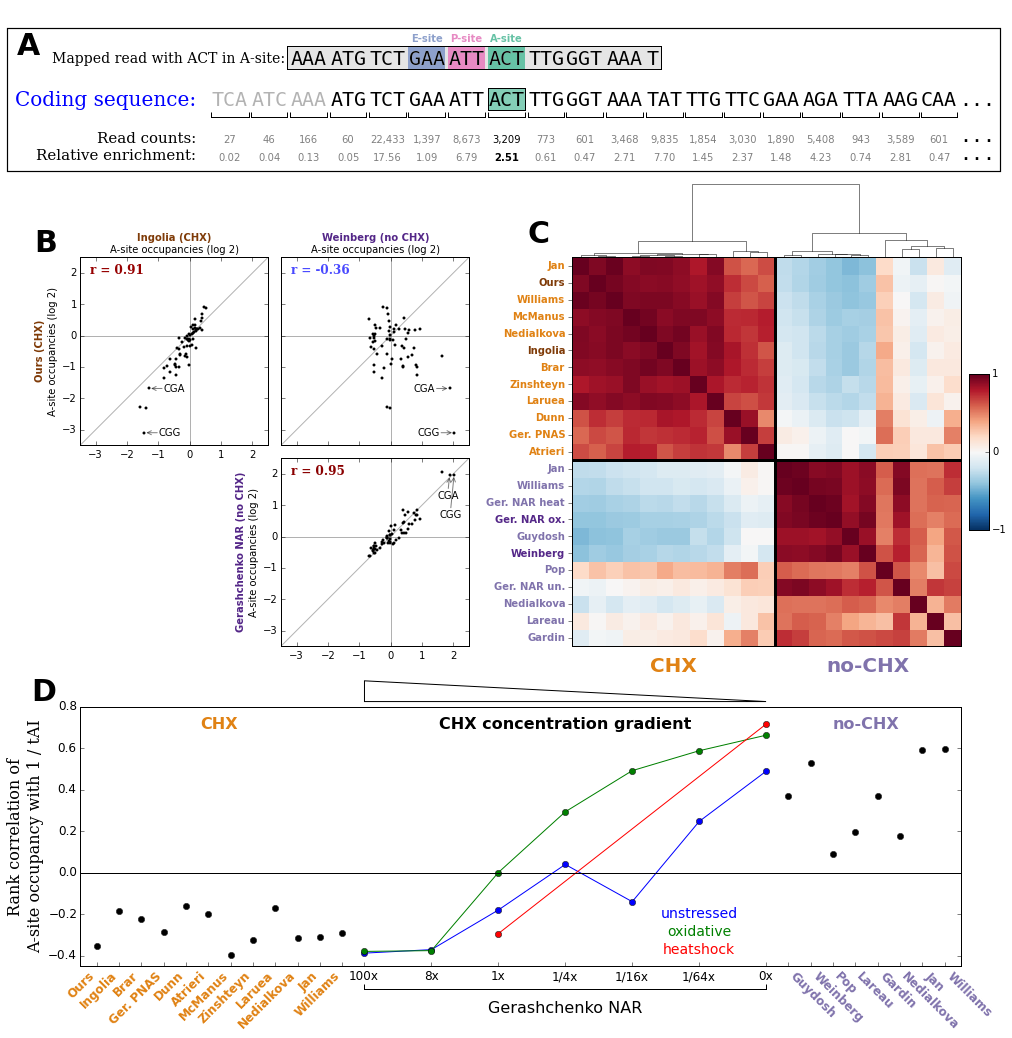

In [48]:
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, gradient_names,
                                  'WT_2_FP', 'Footprints-rich-1',
                                  'oxidative_noCHX', 'RPF',
                                  show_tAI=True,
                                  tRNA_values='tAI',
                                  annotate_matrix=True,
                                  )

fig.savefig('paper/heatmap.png', bbox_inches='tight')

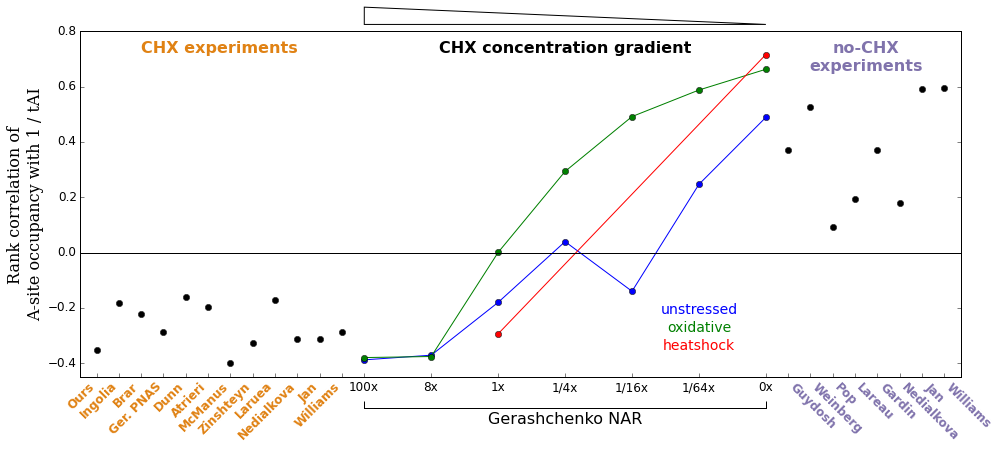

In [23]:
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, gradient_names,
                                   'WT_2_FP', 'Footprints-rich-1',
                                   'oxidative_noCHX', 'RPF',
                                   show_tAI=True,
                                  show_cartoon=False,
                                  show_matrix=False,
                                  show_scatters=False,
                                   tRNA_values='tAI',
                                  draw_letters=False,
                                  )

fig.savefig('paper/tAI_gradient.png', bbox_inches='tight')

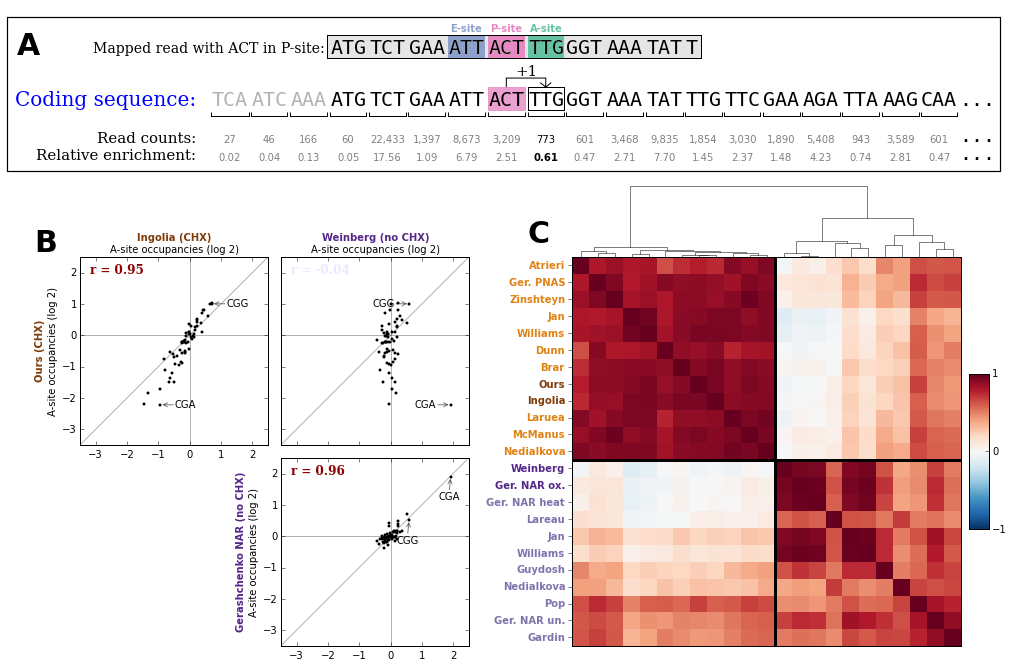

In [24]:
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, gradient_names,
                                   'WT_2_FP', 'Footprints-rich-1',
                                   'oxidative_noCHX', 'RPF',
                                   offset=-1,
                                   show_tAI=False,
                                  )

fig.savefig('paper/heatmap_P_site.png', bbox_inches='tight')

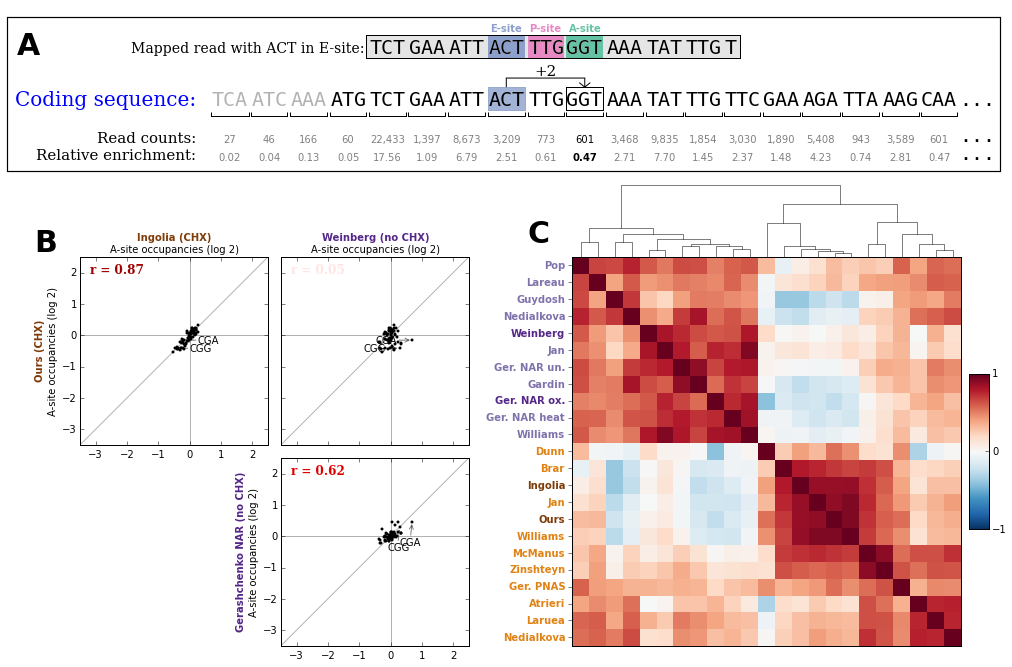

In [25]:
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, gradient_names,
                                   'WT_2_FP', 'Footprints-rich-1',
                                   'oxidative_noCHX', 'RPF',
                                   offset=-2,
                                   show_tAI=False,
                                   draw_dividing_line=False,
                                  )

fig.savefig('paper/heatmap_E_site.png', bbox_inches='tight')

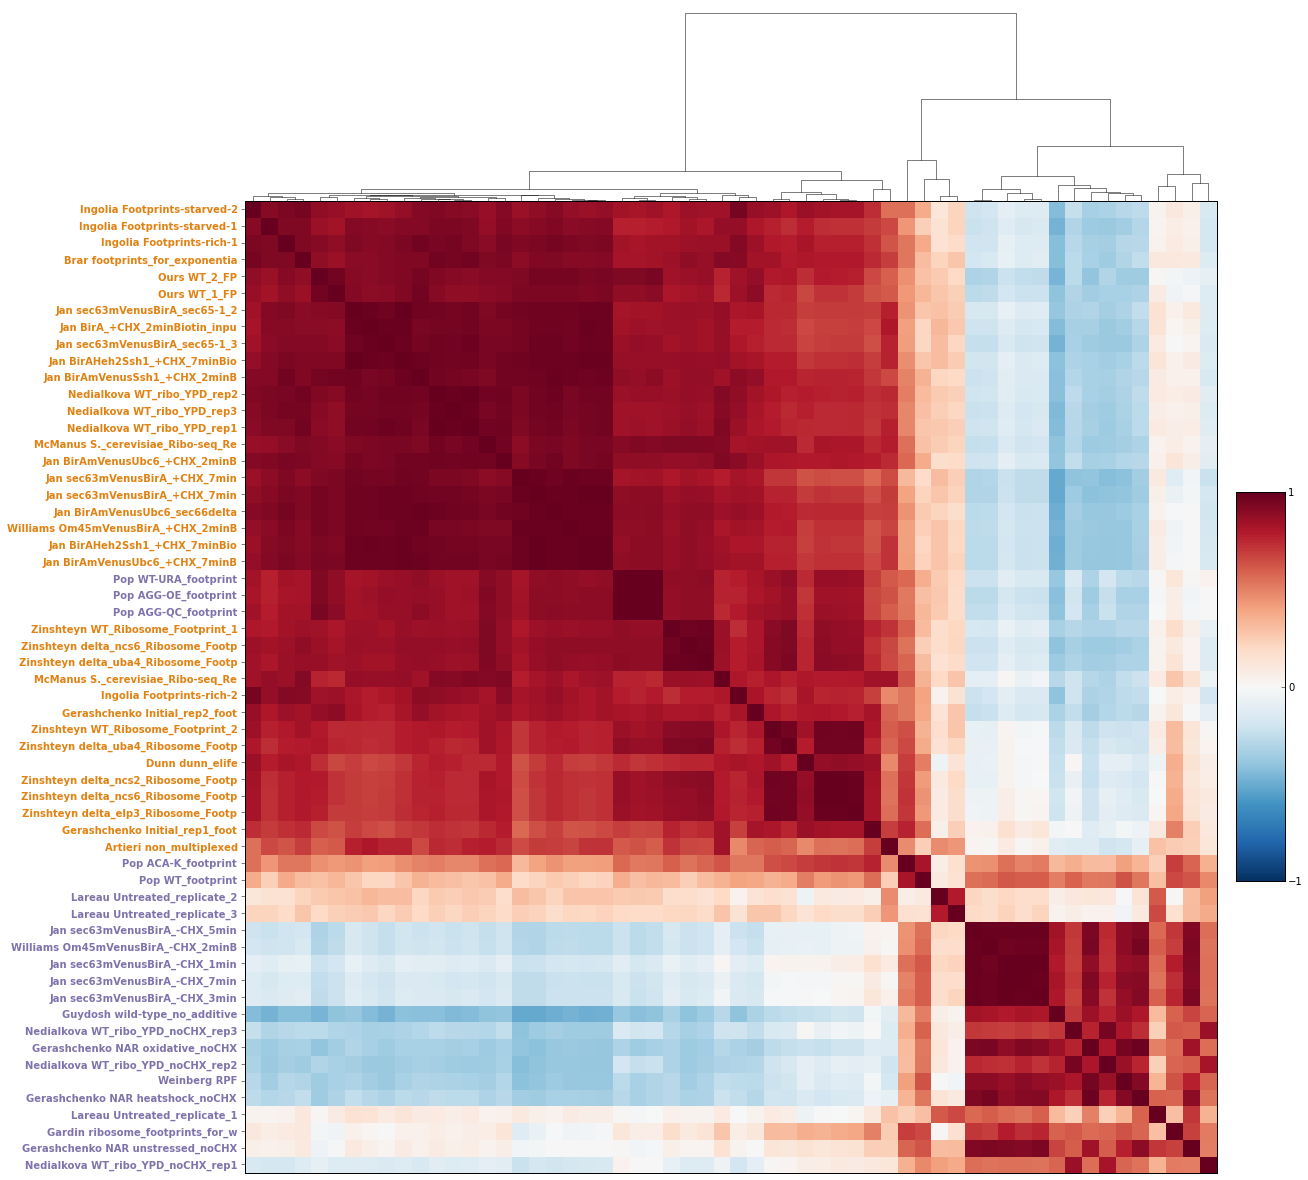

In [9]:
CHX_exps = [
    ('belgium_2014_12_10', lambda n: 'FP' in n and 'WT' in n, 'Ours'),
    ('ingolia_science', lambda n: 'Footprints' in n, 'Ingolia'),
    ('zinshteyn_plos_genetics', lambda n: 'Footprint' in n, 'Zinshteyn'),
    ('mcmanus_gr', lambda n: 'Ribo' in n, 'McManus'),
    ('gerashchenko_pnas', lambda n: 'Initial' in n and 'foot' in n, 'Gerashchenko'),
    ('nedialkova_cell', lambda n: 'WT_ribo' in n and 'noCHX' not in n and 'YPD' in n, 'Nedialkova'),
    ('dunn_elife', lambda n: 'dunn_elife' in n, 'Dunn'),
    ('artieri_gr_2', lambda n: 'non_multiplexed' in n, 'Artieri'),
    ('brar_science', lambda n: 'footprints' in n, 'Brar'),
    ('jan_science', lambda n: '+CHX' in n and 'input' in n, 'Jan'),
    ('williams_science', lambda n: '+CHX' in n and 'input' in n, 'Williams'),
]

CHX_names = []
for name, restriction, label in CHX_exps:
    for n in experiments[name]:
        if restriction(n):
            CHX_names.append((n, label + ' ' + n[:25], label))
            
noCHX_exps = [
    ('weinberg', lambda n: 'RPF' in n, 'Weinberg'),
    ('gerashchenko_nar', lambda n: 'noCHX' in n and 'aurin' not in n and 'edeine' not in n, 'Gerashchenko NAR'),
    ('guydosh_cell', lambda n: 'wild' in n and ('no_additive' in n), 'Guydosh'),
    ('lareau_elife', lambda n: 'Untreated' in n, 'Lareau'),
    ('pop_msb', lambda n: 'footprint' in n, 'Pop'),
    ('gardin_elife', lambda n: 'ribosome_footprints_for_wildtype' in n, 'Gardin'),
    ('nedialkova_cell', lambda n: 'WT_ribo' in n and 'noCHX' in n, 'Nedialkova'),
    ('jan_science', lambda n: '-CHX' in n and 'input' in n, 'Jan'),
    ('williams_science', lambda n: '-CHX' in n and 'input' in n, 'Williams'),
]

noCHX_names = []
for name, restriction, label in noCHX_exps:
    for n in experiments[name]:
        if restriction(n):
            noCHX_names.append((n, label + ' ' + n[:25], label))
            
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, [['oxidative_noCHX']],
                                   'WT_2_FP', 'Footprints-rich-1',
                                   'WT_footprint', 'ACA-K_footprint',
                                   offset=0,
                                   show_tAI=False,
                                   show_scatters=False,
                                   draw_dividing_line=False,
                                   draw_letters=False,
                                   size=30,
                                  show_cartoon=False,
                                  )

fig.savefig('paper/pop_clustering.png', bbox_inches='tight')

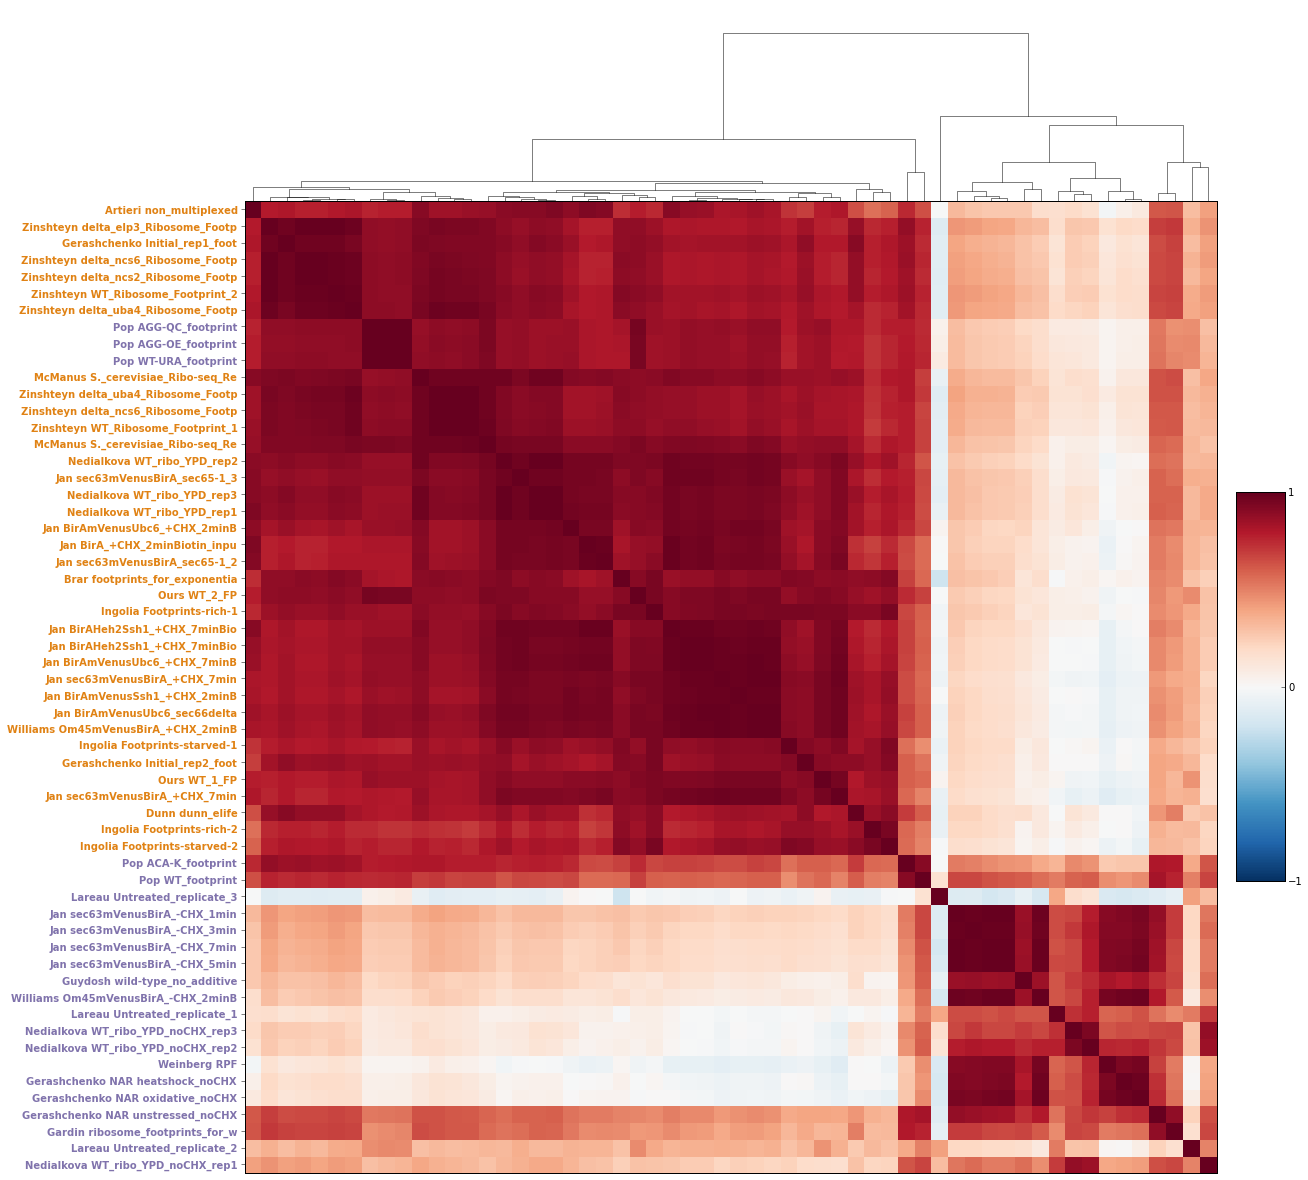

In [10]:
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, [['oxidative_noCHX']],
                                  'WT_2_FP', 'Footprints-rich-1',
                                  'WT_footprint', 'ACA-K_footprint',
                                  offset=-1,
                                  show_tAI=False,
                                  show_scatters=False,
                                  draw_dividing_line=False,
                                  draw_letters=False,
                                  size=30,
                                  show_cartoon=False,
                                 )

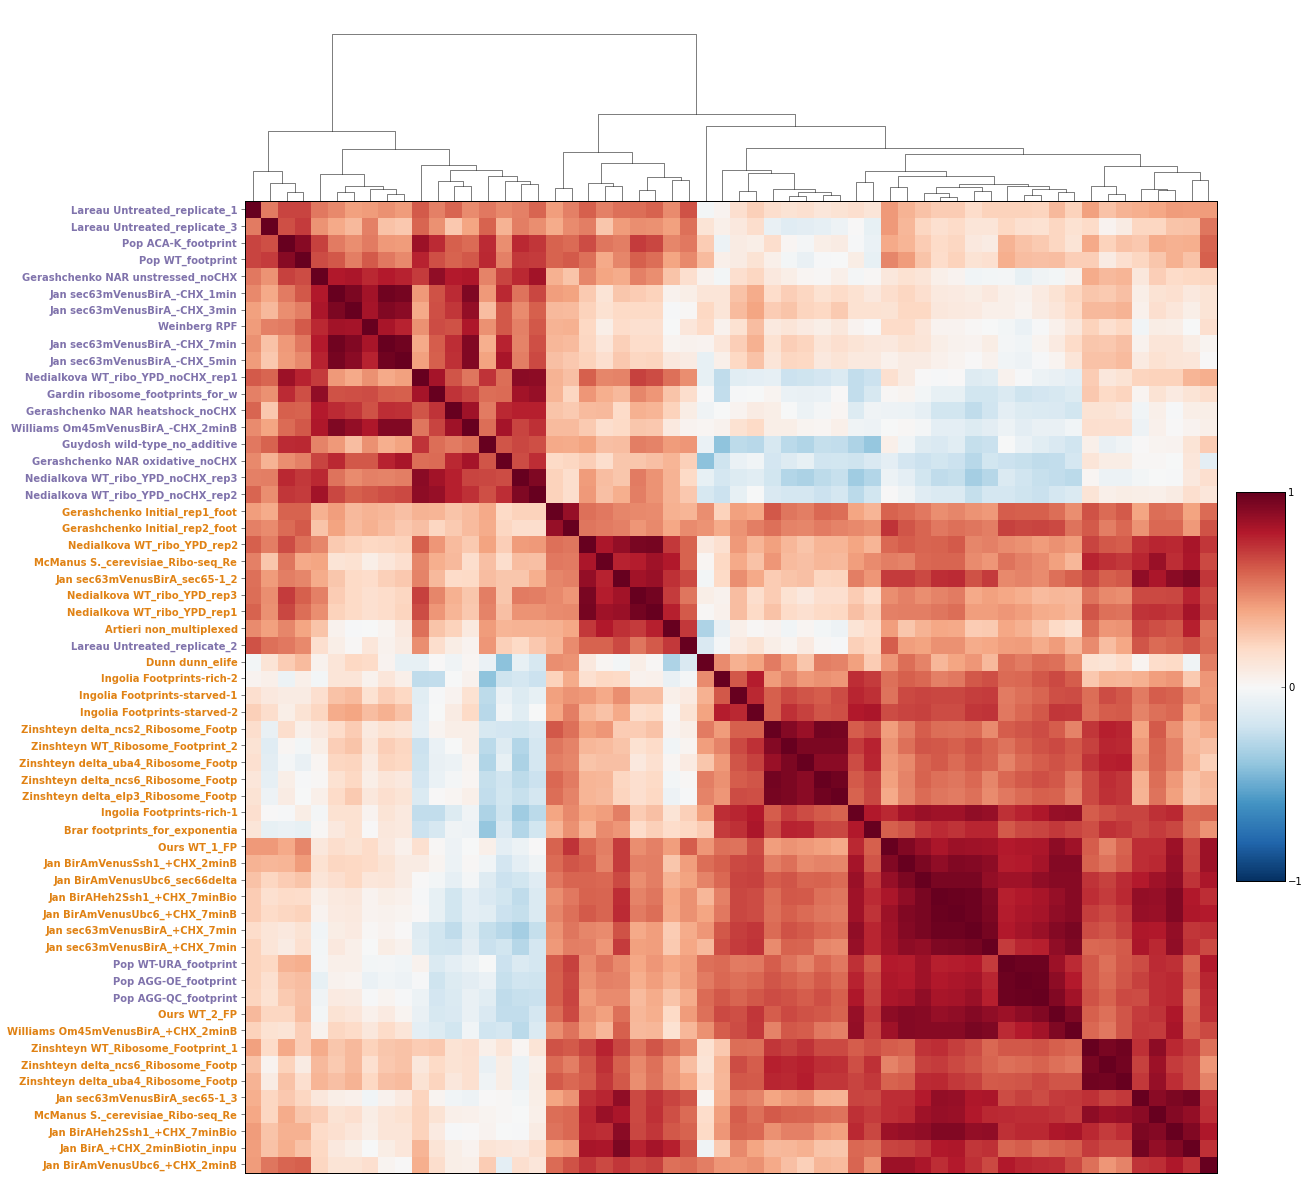

In [11]:
fig = correlation_heatmap_cartoon(enrichments, CHX_names, noCHX_names, [['oxidative_noCHX']],
                                  'WT_2_FP', 'Footprints-rich-1',
                                  'WT_footprint', 'ACA-K_footprint',
                                  offset=-2,
                                  show_tAI=False,
                                  show_scatters=False,
                                  draw_dividing_line=False,
                                  draw_letters=False,
                                  size=30,
                                  show_cartoon=False,
                                 )

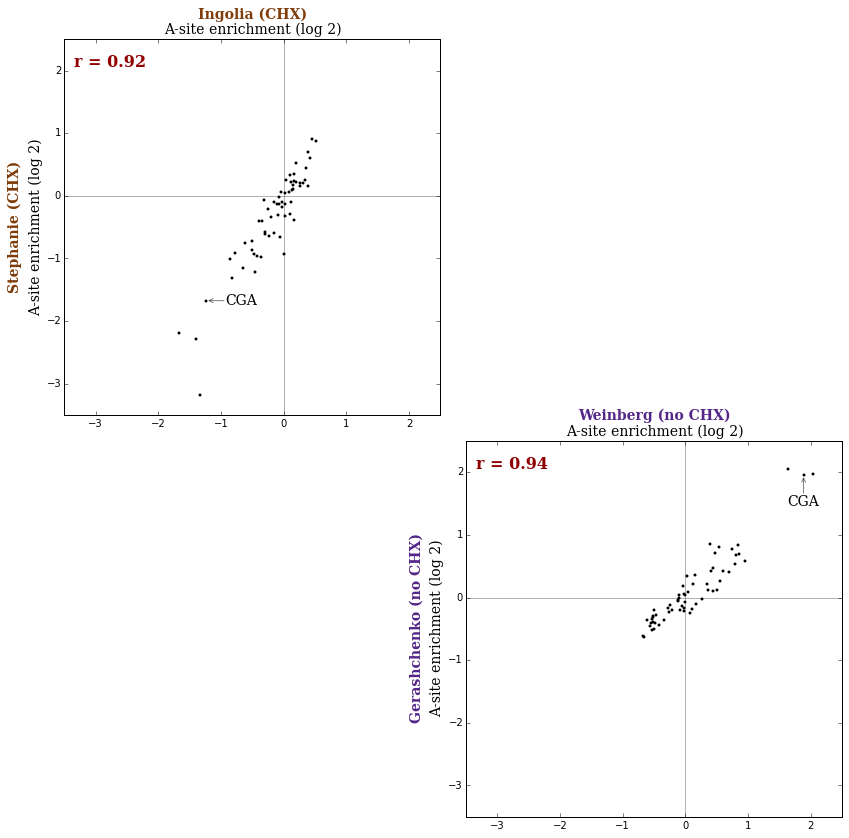

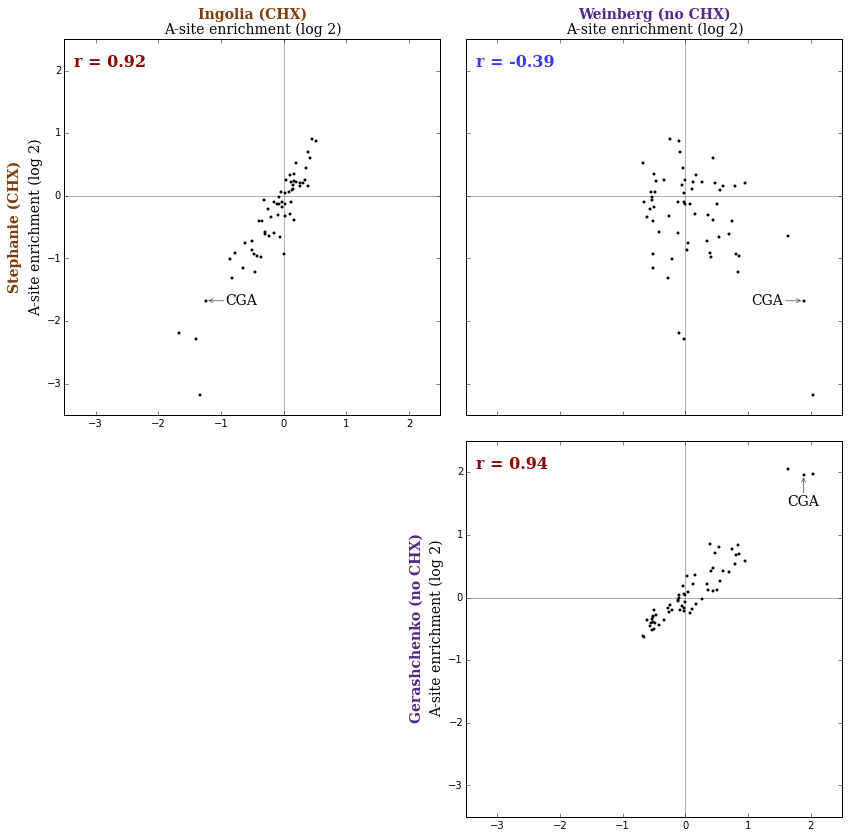

In [6]:
def scatter_pair(enrichments, x_name, y_name,
                 offset=0,
                 text_location='upper right',
                 ax=None,
                 manual_ratios=(0.25, -1.),
                 manual_alignments=('center', 'top')
                ):
    if ax == None:
        fig, ax = plt.subplots(figsize=(16, 16))
    else:
        fig = ax.get_figure()

    xs = np.array([enrichments[x_name]['codon', offset, codon_id] for codon_id in codons.non_stop_codons])
    ys = np.array([enrichments[y_name]['codon', offset, codon_id] for codon_id in codons.non_stop_codons])

    xs = np.log2(xs)
    ys = np.log2(ys)

    Sequencing.Visualize.enhanced_scatter(xs, ys, ax,
                                          color_by_density=False,
                                          show_p_value=False,
                                          marker_size=8,
                                          do_fit=False,
                                          text_location=text_location,
                                          text_size=16,
                                          text_weight='bold',
                                          color_by_correlation=True,
                                         )
    
    labels = np.array(codons.non_stop_codons)
    to_label = (labels == 'CGA')
    pausing.label_scatter_plot(ax, xs, ys, labels, to_label,
                               vector='manual',
                               manual_ratios=manual_ratios,
                               manual_alignments=manual_alignments,
                               initial_distance=20,
                               arrow_alpha=0.5,
                               text_kwargs={'size': 14, 'family': 'serif'},
                              )

    ax.set_xlim(-3.5, 2.5)
    ax.set_ylim(-3.5, 2.5)
    ax.set_aspect('equal')

    kwargs = {'color': 'black',
              'alpha': 0.3,
             }

    ax.axhline(0, **kwargs)
    ax.axvline(0, **kwargs)

def just_scatters(enrichments, CHX_names, noCHX_names, CHX_1_name, CHX_2_name, noCHX_1_name, noCHX_2_name,
                  delete_upper_right=False,
                 ):
    CHX_names, CHX_sources, CHX_long_sources = zip(*CHX_names)
    noCHX_names, noCHX_sources, no_CHX_long_sources = zip(*noCHX_names)
    
    names = CHX_names + noCHX_names
    sources = CHX_sources + noCHX_sources
    long_sources = CHX_long_sources + no_CHX_long_sources
    
    CHX_1_long_source = long_sources[names.index(CHX_1_name)]
    CHX_2_long_source = long_sources[names.index(CHX_2_name)]
    noCHX_1_long_source = long_sources[names.index(noCHX_1_name)]
    noCHX_2_long_source = long_sources[names.index(noCHX_2_name)]
    
    tAIs = pausing.load_tRNA_copy_numbers()
    tAI_values = [tAIs[codon] for codon in codons.non_stop_codons]
    
    all_values = [enrichments[name]['codon', 0, codons.non_stop_codons] for name in names]
    correlations = np.zeros((len(names), len(names)))
    for row, row_values in enumerate(all_values):
        for col, col_values in enumerate(all_values):
            correlations[row, col], _ = scipy.stats.pearsonr(row_values, col_values)
    
    size = 24
    
    row_gap = 0.05
    
    scatter_height = scatter_width = 0.2175
    scatter_gap = 0.015
    
    total_width = scatter_width * 2 + scatter_gap
    total_height = scatter_height * 2 + scatter_gap
    
    fig = plt.figure(figsize=(size * total_width, size * total_height))
      
    scatter_x = 0
    scatter_y = 0
    UL_scatter_ax = fig.add_axes([scatter_x / total_width, (scatter_y + scatter_height + scatter_gap) / total_height, scatter_width / total_width, scatter_height / total_height])
    UR_scatter_ax = fig.add_axes([(scatter_x + scatter_width + scatter_gap) / total_width, (scatter_y + scatter_height + scatter_gap) / total_height, scatter_width / total_width, scatter_height / total_height])
    LR_scatter_ax = fig.add_axes([(scatter_x + scatter_width + scatter_gap) / total_width, scatter_y / total_height, scatter_width / total_width, scatter_height / total_height])
    
    bmap = brewer2mpl.get_map('PuOR', 'Diverging', 10)
    dark_CHX = bmap.mpl_colors[0]
    light_CHX = bmap.mpl_colors[2]
    dark_noCHX = bmap.mpl_colors[-2]
    light_noCHX = bmap.mpl_colors[-3]
               
    scatter_kwargs = {'text_location': 'upper left',              
                     }
  
    scatter_pair(enrichments,
                 CHX_2_name, CHX_1_name,
                 ax=UL_scatter_ax,
                 manual_ratios=(1., 0.),
                 manual_alignments=('left', 'center'),
                 **scatter_kwargs)
    
    scatter_pair(enrichments,
                 noCHX_2_name, CHX_1_name,
                 ax=UR_scatter_ax,
                 manual_ratios=(-1., 0.),
                 manual_alignments=('right', 'center'),
                 **scatter_kwargs)
    
    scatter_pair(enrichments,
                 noCHX_2_name, noCHX_1_name,
                 ax=LR_scatter_ax,
                 manual_ratios=(0, -1.),
                 manual_alignments=('center', 'top'),
                 **scatter_kwargs)
      
    font_kwargs = {'size': 14,
                   'family': 'serif',
                  }
    
    UL_scatter_ax.set_xlabel('A-site enrichment (log 2)', **font_kwargs)
    UL_scatter_ax.xaxis.set_label_position('top')
    UL_scatter_ax.xaxis.set_tick_params(labeltop='off', labelbottom='on')
    UL_scatter_ax.set_ylabel('A-site enrichment (log 2)', **font_kwargs)
    UL_scatter_ax.yaxis.set_tick_params(labelleft='on', labelright='off')
    
    UL_scatter_ax.annotate(CHX_1_long_source,
                           xy=(0, 0.5),
                           xycoords='axes fraction',
                           xytext=(-50, 0),
                           textcoords='offset points',
                           rotation=90,
                           ha='center',
                           va='center',
                           color=dark_CHX,
                           weight='bold',
                           **font_kwargs)
    
    UL_scatter_ax.annotate(CHX_2_long_source,
                           xy=(0.5, 1),
                           xycoords='axes fraction',
                           xytext=(0, 25),
                           textcoords='offset points',
                           ha='center',
                           va='center',
                           color=dark_CHX,
                           weight='bold',
                           **font_kwargs)
    
    if delete_upper_right:
        fig.delaxes(UR_scatter_ax)
        right_to_label_ax = LR_scatter_ax
    else:
        right_to_label_ax = UR_scatter_ax
        UR_scatter_ax.xaxis.set_tick_params(labeltop='off', labelbottom='off')
        UR_scatter_ax.yaxis.set_tick_params(labelleft='off', labelright='off')
    
    right_to_label_ax.set_xlabel('A-site enrichment (log 2)', **font_kwargs)
    right_to_label_ax.xaxis.set_label_position('top')
    
    LR_scatter_ax.set_ylabel('A-site enrichment (log 2)', **font_kwargs)
    LR_scatter_ax.yaxis.set_tick_params(labelleft='on', labelright='off')
    
    LR_scatter_ax.annotate(noCHX_1_long_source,
                           xy=(0, 0.5),
                           xycoords='axes fraction',
                           xytext=(-50, 0),
                           textcoords='offset points',
                           rotation=90,
                           ha='center',
                           va='center',
                           color=dark_noCHX,
                           weight='bold',
                           **font_kwargs)
    
    right_to_label_ax.annotate(noCHX_2_long_source,
                           xy=(0.5, 1),
                           xycoords='axes fraction',
                           xytext=(0, 25),
                           textcoords='offset points',
                           ha='center',
                           va='center',
                           color=dark_noCHX,
                           weight='bold',
                           **font_kwargs)
        
    return fig

CHX_names = [
    ('WT_2_FP', 'Stephanie', 'Stephanie (CHX)'),
    ('Footprints-rich-1', 'Ingolia', 'Ingolia (CHX)'),
]

noCHX_names = [
    ('RPF', 'Weinberg', 'Weinberg (no CHX)'),
    ('oxidative_noCHX', 'Ger. NAR ox.', 'Gerashchenko (no CHX)'),
]

fig = just_scatters(enrichments, CHX_names, noCHX_names,
                    'WT_2_FP', 'Footprints-rich-1',
                    'oxidative_noCHX', 'RPF',
                    delete_upper_right=True,
                   )

fig.savefig('bdibs/three_scatters_just_two.png', bbox_inches='tight')

fig = just_scatters(enrichments, CHX_names, noCHX_names,
                    'WT_2_FP', 'Footprints-rich-1',
                    'oxidative_noCHX', 'RPF',
                    delete_upper_right=False,
                   )

fig.savefig('bdibs/three_scatters.png', bbox_inches='tight')

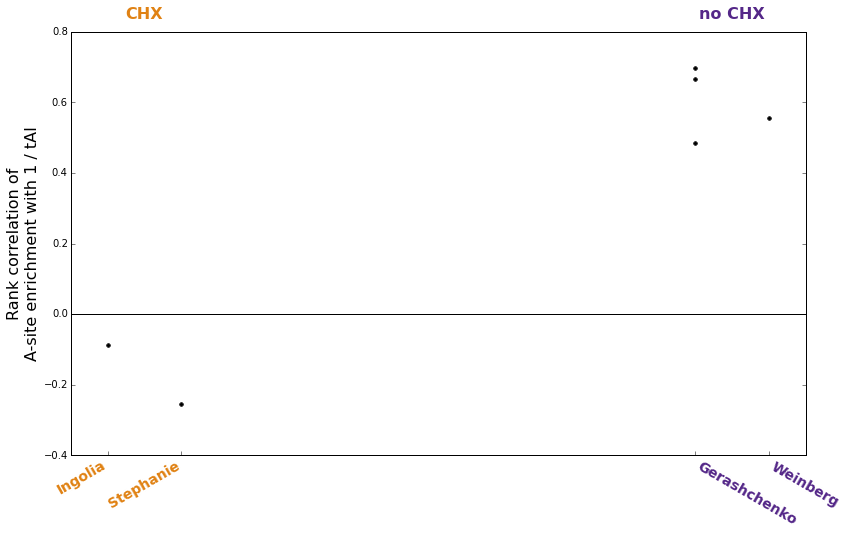

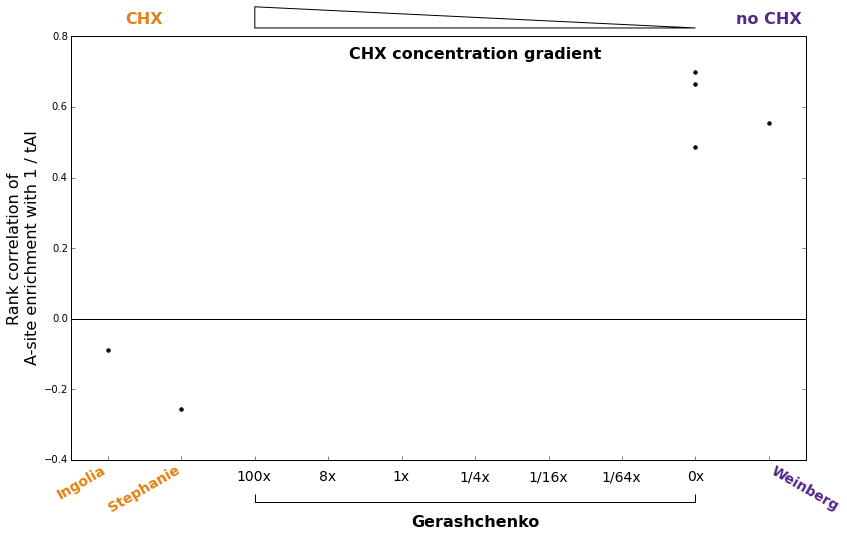

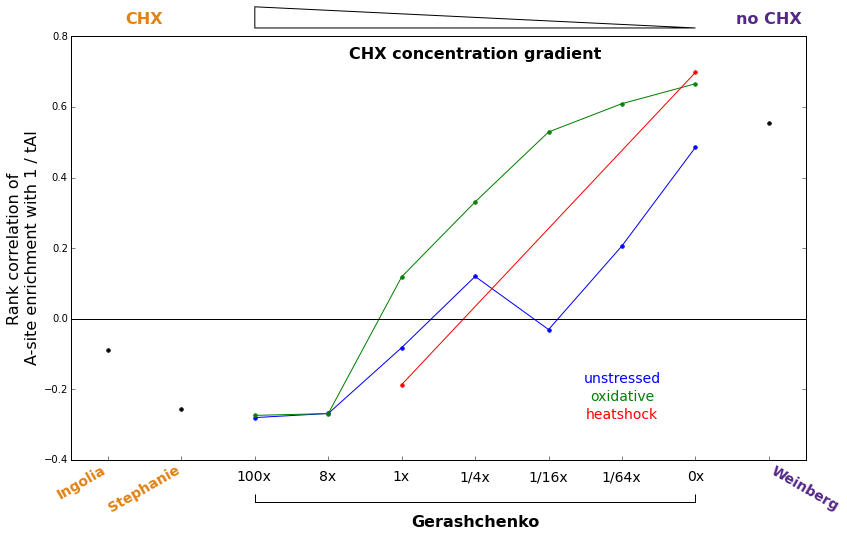

In [35]:
def get_gradient_labels(name_order): 
    gradient_fractions = [select_work.gerashchenko_fraction(name) for name in name_order]
 
    gradient_labels = [str(num) + ('/{0}x'.format(denom) if denom != 1 else 'x')
                       for num, denom, rep in gradient_fractions
                      ]

    return tuple(gradient_labels)

def bracket_below_range(x_min, x_max, ax, color='black'):
    bracket_x_buffer = 0
    bracket_height = 0.02
    bracket_y_buffer = -0.1
    
    left, _ = ax.transLimits.transform([x_min, 0])
    right, _ = ax.transLimits.transform([x_max, 0])

    bottom = bracket_y_buffer
    top = bottom + bracket_height

    path = [[left - bracket_x_buffer, top],
            [left - bracket_x_buffer, bottom],
            [right + bracket_x_buffer, bottom],
            [right + bracket_x_buffer, top],
           ]

    patch = plt.Polygon(path,
                        color=color,
                        fill=False,
                        closed=False,
                        clip_on=False,
                        transform=ax.transAxes,
                       )

    ax.add_patch(patch)
    
def just_gradient(enrichments, CHX_names, noCHX_names, gradient_names, show_gradient_data=True, show_gradient_trappings=True):
    CHX_names, CHX_sources, CHX_long_sources = zip(*CHX_names)
    noCHX_names, noCHX_sources, no_CHX_long_sources = zip(*noCHX_names)
    
    names = CHX_names + noCHX_names
    sources = CHX_sources + noCHX_sources
    long_sources = CHX_long_sources + no_CHX_long_sources

    tAIs = pausing.load_tRNA_copy_numbers()
    tAI_values = [tAIs[codon] for codon in codons.non_stop_codons]
    
    size = 12
    
    tAI_height = 0.7
    tAI_width = 1.
    
    row_gap = 0.05
    
    total_width = tAI_width
    total_height = tAI_height
    
    fig = plt.figure(figsize=(size * total_width, size * total_height))
    
    tAI_ax = fig.add_axes([0.1, 0.15, 0.85 * tAI_width / total_width, 0.7 * tAI_height / total_height])
        
    bmap = brewer2mpl.get_map('PuOR', 'Diverging', 10)
    dark_CHX = bmap.mpl_colors[0]
    light_CHX = bmap.mpl_colors[2]
    dark_noCHX = bmap.mpl_colors[-2]
    light_noCHX = bmap.mpl_colors[-3]
               
    name_to_tAI_correlation = {}
    for name_list in [CHX_names, noCHX_names] + gradient_names:
        for name in name_list:
            if name == None:
                continue
                
            values = enrichments[name]['codon', 0, codons.non_stop_codons]
            rho, _ = scipy.stats.spearmanr(values, tAI_values)
            name_to_tAI_correlation[name] = rho
            
    CHX_xs = np.arange(len(CHX_names))
    gradient_xs_list = [[len(CHX_names) + i for i, name in enumerate(condition) if name != None] for condition in gradient_names]
    
    noCHX_start = len(CHX_names) + max(map(len, gradient_names))
    
    # exclude gersarchenko NAR samples from being plotted a second time
    relevant_noCHX_names = [name for name in noCHX_names if 'noCHX' not in name]
    relevant_noCHX_sources = tuple([source for name, source in zip(noCHX_names, noCHX_sources) if name in relevant_noCHX_names])
    noCHX_xs = np.arange(noCHX_start, noCHX_start + len(relevant_noCHX_names))
    
    gradient_start = max(CHX_xs) + 1
    gradient_end = min(noCHX_xs) - 1
    
    CHX_ys = [name_to_tAI_correlation[name] for name in CHX_names]
    noCHX_ys = [name_to_tAI_correlation[name] for name in relevant_noCHX_names]
    gradient_ys_list = [[name_to_tAI_correlation[name] for name in gradient if name != None] for gradient in gradient_names]
    
    if show_gradient_trappings:
        tAI_ax.set_xticks(np.concatenate((CHX_xs, gradient_xs_list[0], noCHX_xs)))
        tAI_ax.set_xticklabels(CHX_sources + get_gradient_labels(gradient_names[0]) + relevant_noCHX_sources)
    else:
        tAI_ax.set_xticks(np.concatenate((CHX_xs, [noCHX_xs[0] - 1], noCHX_xs)))
        tAI_ax.set_xticklabels(CHX_sources + ('Gerashchenko',) + relevant_noCHX_sources)
    
    if not show_gradient_data:
        gradient_xs_list = [l[-1:] for l in gradient_xs_list]
        gradient_ys_list = [l[-1:] for l in gradient_ys_list]
        
    tAI_ax.xaxis.tick_bottom()
    
    gradient_labels = [name_list[-1].split('_')[0] for name_list in gradient_names]
    gradient_colors = []
    
    tAI_ax.plot(CHX_xs, CHX_ys, '.', markersize=8, color='black')
    tAI_ax.plot(noCHX_xs, noCHX_ys, '.', markersize=8, color='black')
    for gradient_xs, gradient_ys, label in zip(gradient_xs_list, gradient_ys_list, gradient_labels):
        if not show_gradient_data:
            kwargs = {'color': 'black'}
        else:
            kwargs = {}
        lines, = tAI_ax.plot(gradient_xs, gradient_ys, '.-', label=label, markersize=8, **kwargs)
        gradient_colors.append(lines.get_color())
        
    tAI_ax.axhline(0, color='black')
    tAI_ax.set_xlim(-0.5, max(noCHX_xs) + 0.5)
    
    if show_gradient_trappings:
        bracket_below_range(gradient_start, gradient_end, tAI_ax, color='black')
        triangle = matplotlib.patches.Polygon(np.array([[gradient_start, 1.02], [gradient_end, 1.02], [gradient_start, 1.07]]),
                                              transform=tAI_ax.get_xaxis_transform(),
                                              clip_on=False,
                                              color='black',
                                              fill=False,
                                             )

        tAI_ax.add_patch(triangle)

        tAI_ax.annotate('CHX concentration gradient',
                    xy=((gradient_start + gradient_end) / 2., 1),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, -10),
                    textcoords='offset points',
                    ha='center',
                    va='top',
                    size=16,
                    weight='bold',
                 )
    
        tAI_ax.annotate('Gerashchenko',
                        xy=((gradient_start + gradient_end) / 2., 0),
                        xycoords=('data', 'axes fraction'),
                        xytext=(0, -55),
                        textcoords='offset points',
                        ha='center',
                        va='top',
                        size=16,
                        weight='bold',
                     )
        
        y_offset = 0
        
    if show_gradient_data:
        for gradient_label, gradient_color in zip(gradient_labels, gradient_colors):
            tAI_ax.annotate(gradient_label,
                            xy=(gradient_end - 1, 0.175),
                            xycoords=('data', 'axes fraction'),
                            xytext=(0, y_offset),
                            textcoords='offset points',
                            ha='center',
                            va='bottom',
                            size=14,
                            color=gradient_color,
                           )
            y_offset -= 14 + 4

    for _, label in zip(CHX_names, tAI_ax.get_xticklabels()):
        label.set_color(light_CHX)
        label.set_rotation(30)
        label.set_ha('right')
        label.set_weight('semibold')

    labels_to_rotate = relevant_noCHX_names[::-1]
    if not show_gradient_trappings:
        labels_to_rotate += ['']
    for _, label in zip(labels_to_rotate, tAI_ax.get_xticklabels()[::-1]):
        label.set_color(dark_noCHX)
        label.set_rotation(-30)
        label.set_ha('left')
        label.set_weight('semibold')
        
    for tick, label in zip(tAI_ax.xaxis.get_major_ticks(), tAI_ax.xaxis.get_majorticklabels()):
        if 'x' in label.get_text():
            tick.set_pad(10)

    for label in tAI_ax.get_xticklabels():
        label.set_size(14)
    
    tAI_ax.set_ylabel('Rank correlation of\nA-site enrichment with 1 / tAI', size=16)
    
    tAI_ax.annotate('CHX',
                    xy=(max(CHX_xs) / 2., 1),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    color=light_CHX,
                    size=16,
                    weight='bold',
                 )
    
    tAI_ax.annotate('no CHX',
                    xy=((gradient_end + (1 if show_gradient_trappings else 0) + max(noCHX_xs)) / 2., 1),
                    xycoords=('data', 'axes fraction'),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    size=16,
                    color=dark_noCHX,
                    weight='bold',
                 )
        
    return fig

CHX_names = [
    ('Footprints-rich-1', 'Ingolia', 'Ingolia (CHX)'),
    ('WT_2_FP', 'Stephanie', 'Stephanie (CHX)'),
]

noCHX_names = [
    ('RPF', 'Weinberg', 'Weinberg (no CHX)'),
    ('oxidative_noCHX', 'Ger. NAR ox.', 'Gerashchenko (no CHX)'),
]

gradient_names = [
    ['unstressed_100x_CHX_rep1',
     'unstressed_8x_CHX',
     'unstressed_1x_CHX',
     'unstressed_1_4x_CHX',
     'unstressed_1_16x_CHX',
     'unstressed_1_64x_CHX',
     'unstressed_noCHX',
    ],
    ['oxidative_100x_CHX_rep1',
     'oxidative_8x_CHX',
     'oxidative_1x_CHX',
     'oxidative_1_4x_CHX',
     'oxidative_1_16x_CHX',
     'oxidative_1_64x_CHX',
     'oxidative_noCHX',
    ],
    [None,
     None,
     'heatshock_1x_CHX',
     None,
     None,
     None,
     'heatshock_noCHX',
    ],
]

fig = just_gradient(enrichments, CHX_names, noCHX_names, gradient_names, show_gradient_data=False, show_gradient_trappings=False)
fig.savefig('bdibs/tAI_initial.png')
fig = just_gradient(enrichments, CHX_names, noCHX_names, gradient_names, show_gradient_data=False, show_gradient_trappings=True)
fig.savefig('bdibs/tAI_with_trappings.png')
fig = just_gradient(enrichments, CHX_names, noCHX_names, gradient_names)
fig.savefig('bdibs/tAI_with_data.png')